In [1]:
# data manipulation
import numpy as np
import pandas as pd
# clustering algo
from sklearn.cluster import KMeans
# visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# printing results
import matplotlib.pyplot as plt
# encoding labels
from sklearn.preprocessing import LabelEncoder
# progress bar
from tqdm.notebook import tqdm_notebook
# scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# loading python objects
import pickle
# silhouette computing
from sklearn.metrics import silhouette_samples, silhouette_score

In this notebook I'm going to do a cluster analysis of the dataset using the features extracted with elaboration.ipybn.<br>The visualization is done by using log mel-spectrograms since is no reccommended using directly the MFCC because the DCT step decorellates the features. Istead MFCC+delta are used to apply clustering.

# Loading data

We start by loading the metadata of our pre-processed containing all the information...

In [2]:
metadata = pd.read_csv("processed_metadata.csv")
metadata.head()

,path,segment,mod,label,samplingrate,ms,samples
0,./Labelled/Bleatings/evt_000_000_000681_210415...,0,0,Bleatings,16000,3000.0,processed_samples/0.wav
1,./Labelled/Bleatings/evt_000_000_000681_210415...,1,0,Bleatings,16000,3000.0,processed_samples/1.wav
2,./Labelled/Bleatings/evt_000_000_000681_210415...,2,0,Bleatings,16000,3000.0,processed_samples/2.wav
3,./Labelled/Bleatings/evt_000_000_000681_210415...,3,0,Bleatings,16000,3000.0,processed_samples/3.wav
4,./Labelled/Bleatings/evt_000_000_000682_210415...,0,0,Bleatings,16000,3000.0,processed_samples/4.wav


... and extract the label for each sample.

In [3]:
# Separating out the target
y = metadata['label']
#Scaling the feature columns
encoder = LabelEncoder()
y = encoder.fit_transform(y)
np.shape(y)

(6944,)

Next the data of the log mel spetrograms are loaded

In [4]:
logmelspectrograms = pickle.load(open("logmelspectrograms_data.p", "rb" ))
np.shape(logmelspectrograms)

(6944, 128, 94)

Since the samples are in tabular form is compulsory to flatten each matrix to a single row

In [5]:
logmelspectrograms = [sample.flatten() for sample in logmelspectrograms]
np.shape(logmelspectrograms)

(6944, 12032)

Next standardize each column to apply PCA afterwards

In [6]:
scaler = StandardScaler()
logmelspectrograms = scaler.fit_transform(logmelspectrograms)

Load MFCC and delta-MFCC features for k-means

In [7]:
features = pd.read_csv("mfcc_deltamfcc_stat.csv")
np.shape(features)

(6944, 130)

In [8]:
features = scaler.fit_transform(features)

# Visualization

Let's start by defining a way to visualize our dataset. A good starting point is to take the 2 principal component obtained by PCA over the logmelspectrograms data and plot them.

In [9]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(logmelspectrograms)
pca.explained_variance_ratio_

array([0.40801267, 0.13560335])

The 2 principal component only explain about 54% of the variance in data.<br>Let's plot the obtained axis.

In [14]:
def print_axis(components, targets):
    plt.figure(figsize = (12,8))
    scatter = plt.scatter(components[:, 0], components[:, 1], c=targets, s=10, alpha=0.5)
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    targets = [0,1,2]
    plt.legend(*scatter.legend_elements())

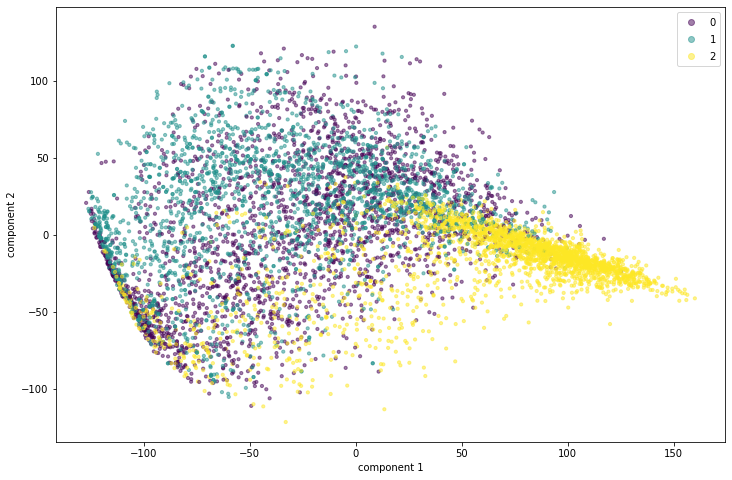

In [34]:
print_axis(principalComponents, y)

The plot is a bit messy... let's try to improve the printing by using T-SNE.<br>To further reduce the noise and speed-up the computation I let PCA to extract the number of principal components to explain at lest 90% of variance and use them for T-SNE.

In [ ]:
pca = PCA(0.9)
principalComponents = pca.fit_transform(logmelspectrograms)
np.sum(pca.explained_variance_ratio_)

In [ ]:
pca.n_components_

This time we captured 90% of variance in data!<br>Apply t-sne over the transformed data and print the result.

In [ ]:
components = TSNE(n_components=2, random_state=50).fit_transform(principalComponents)

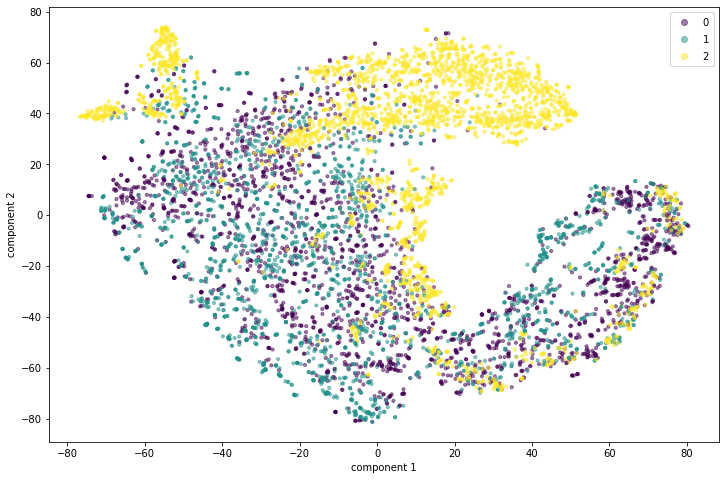

In [15]:
print_axis(components, y)

This way we obtained a slightly better rapprensetation of data! The label 2 (Others) is the most separeted from the others while the others 2 are mixed up, like seen with PCA.

# k-Means Clustering

Let's do basic cluster analysis with k-means to learn more about the difficulty of the problem.<br>I dont excpet very good result since two class are mixed up

In [9]:
kmeans = KMeans(n_clusters=3, random_state=100).fit(features)
labels = pd.Series(kmeans.labels_)
np.shape(labels)

(6944,)

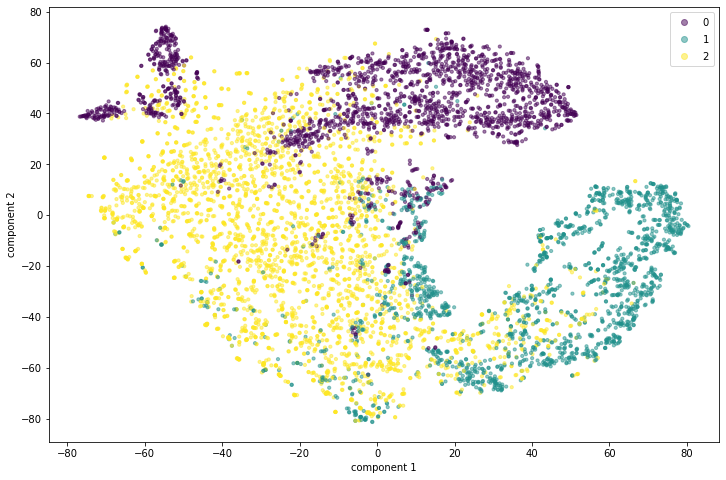

In [17]:
print_axis(components, labels)

Let's put in a list, for each identified class by the clustering, the index of the associated item.

In [18]:
classes = [list(), list(), list()]
for count, label in enumerate(labels):
    if label == 0:
        classes[0].append(count)
    elif label == 1:
        classes[1].append(count)
    else:
        classes[2].append(count)
print(len(classes[0]), len(classes[1]), len(classes[2]))

1924 1840 3180


And count for each element in the identfied clusters in which original labels falls the point

In [19]:
def count_for_class(classes):
    counts = [list(), list(), list()]
    for i in classes:
        if y[i] == 0:
            counts[0].append(i)
        elif y[i] == 1:
            counts[1].append(i)
        else:
            counts[2].append(i)
    return (len(counts[0]), len(counts[1]), len(counts[2]))

In [20]:
for i in range(3):
    count = count_for_class(classes[i])
    print(f"For the cluster {i} we have {count} items in the orignal classes\tThe most promising original class is {np.argmax(count)}")

For the cluster 0 we have (6, 0, 1918) items in the orignal classes	The most promising original class is 2
For the cluster 1 we have (684, 615, 541) items in the orignal classes	The most promising original class is 0
For the cluster 2 we have (1633, 1541, 6) items in the orignal classes	The most promising original class is 0


As can see above, since almost all the points in the cluster 0 are of the class 2, we can correct the color of the labels by inveriting the 0 with 2. Istead much harder is to derive a conclusion about the others two since the they are pretty mixed up and both have 0 as most promising class. However since in % the cluster 2 contains more samples of class 0 i've decided to leave this as it is and assign to cluster 2 label's 0. Cluster 1 is the more mixed class.

In [10]:
# modify obtained labels to reflect the original
labels = [2 if l==0 else 0 if l==2 else 1 for l in labels]

In [22]:
pd.concat((pd.Series(y).value_counts().rename("Original"), pd.Series(labels).value_counts().rename("K-means")), axis=1)

,Original,K-means
0,2323,3180
1,2156,1840
2,2465,1924


Let's visualize both T-SNE and PCA

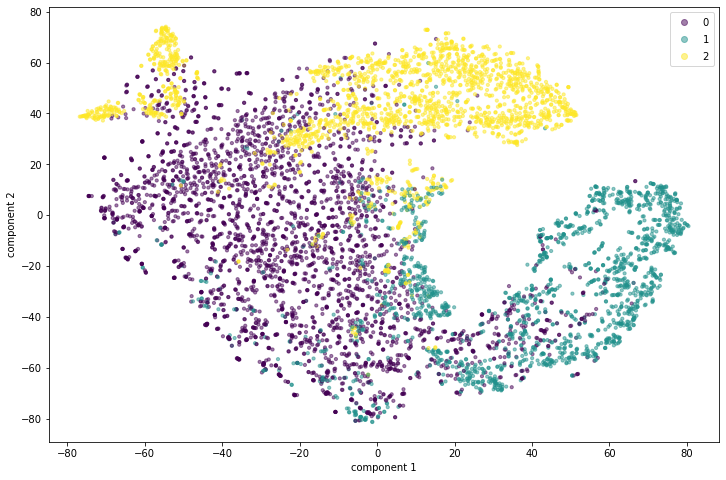

In [23]:
print_axis(components, labels)

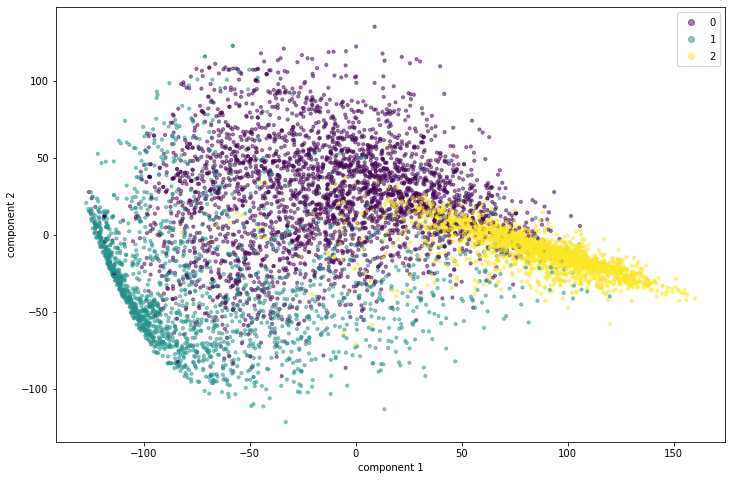

In [24]:
print_axis(principalComponents, labels)

By using 3 clusters, we can see in the plots and in the above conclusion about the counts of the elements in clusters that most of the "other" record get correctrly clustered from the others, but the others two class (which in the orginal dataset are pretty mixed as seen in the first plots) with k-means they get separated in two distinct clusters.<br>Let's have a deep look in the changing of the label between the original data and clustering.

In [25]:
diff = (pd.Series(y)).compare(pd.Series(labels))
print(f"{len(diff)} elements change label out of {len(y)}")
diff.head()

2778 elements change label out of 6944


,self,other
3,0.0,1.0
6,0.0,1.0
8,0.0,1.0
12,0.0,1.0
13,0.0,1.0


In [26]:
differences = [f'{row[0]} -> {row[1]}' for row in diff.to_numpy()]
pd.Series(differences).value_counts()

1.0 -> 0.0    1541
0.0 -> 1.0     684
2.0 -> 1.0     541
0.0 -> 2.0       6
2.0 -> 0.0       6
dtype: int64

As previously assumed we can see almost none of the items with label 0 or 1 change label in 2 (others). This is probably due the fact that I've removed the noise from the first two class and no in others by making this label features very different. <br>Instead some labels change from 2 in 0 or 1: probably the splitting and afterward apply noisereduce leave some samples with a lot of background noise.<br>The most interesting and worrying thing is that a lot of labels change values from  0 (bleatings) to 1 (contact calls) and vice versa. This means that this two class are mixed up (as can also be seen in the plot) and this can be a problem for our classification task.

# Elbow method and Silhouette analysis

Silhouette analysis can be used to determine the degree of separation between clusters, for each sample compute the coefficient and:<ul>
    <li>If it is 0 –> the sample is very close to the neighboring clusters.
    <li>It it is 1 –> the sample is far away from the neighboring clusters.
    <li>It it is -1 –> the sample is assigned to the wrong clusters.
</ul>

In [11]:
 # Get silhouette samples
silhouette_vals = silhouette_samples(features, labels)
silhouette_vals

array([ 0.03745095,  0.00072747,  0.0793118 , ..., -0.06831804,
        0.03334956,  0.13443573])

Text(0, 0.5, 'Cluster labels')

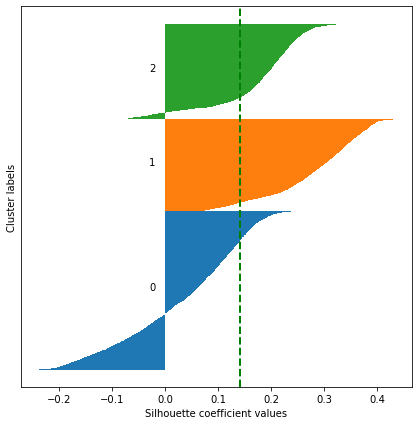

In [13]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(7, 7)
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(labels)):
    cluster_silhouette_vals = silhouette_vals[labels == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    ax1.text(-0.03, (y_lower + y_upper) / 2, str(i))
    y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)

# Get the average silhouette score and plot it
avg_score = silhouette_score(features, labels)
ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
ax1.set_yticks([])
#ax1.set_xlim([-0.1, 1])
ax1.set_xlabel('Silhouette coefficient values')
ax1.set_ylabel('Cluster labels')

As we bee seen in the plot the clustering does not do a great job; for cluster 0 its values are  near 0, meaning overlapping clusters, and others <0, wich mean they are assigend to the wrong cluster or are outliers.

Let's inspect with the elbow method, an empirical method to find the optimal number of clusters for a dataset.

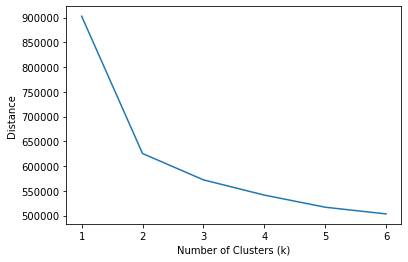

In [29]:
range_n_clusters = [1, 2, 3, 4, 5, 6]
avg_distance=[]
for n_clusters in range_n_clusters:
  clusterer = KMeans(n_clusters=n_clusters, random_state=42).fit(features)
  avg_distance.append(clusterer.inertia_)

plt.plot(range_n_clusters, avg_distance)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distance")
plt.show()

To find the optimal number of clusters (k), observe the plot and find the value of k for which there is a sharp and steep fall of the distance: this is will be an optimal point of k where an elbow occurs. In this case we have k=2

Let's examine Silhoutte values and plot for other values of k

For n_clusters = 2 The average silhouette_score is : 0.2718359934131244
For n_clusters = 3 The average silhouette_score is : 0.14051266608425256
For n_clusters = 4 The average silhouette_score is : 0.10883203524736404
For n_clusters = 5 The average silhouette_score is : 0.11857920860967361
For n_clusters = 6 The average silhouette_score is : 0.07312047957263017


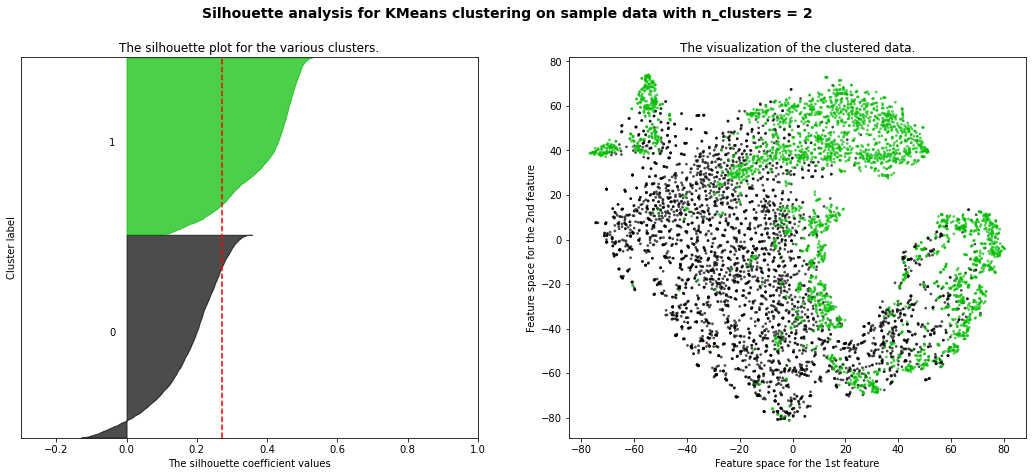

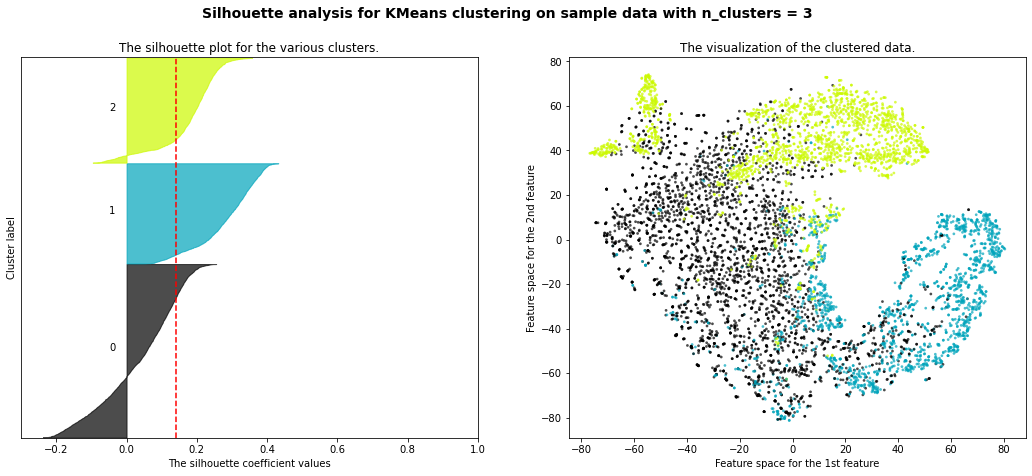

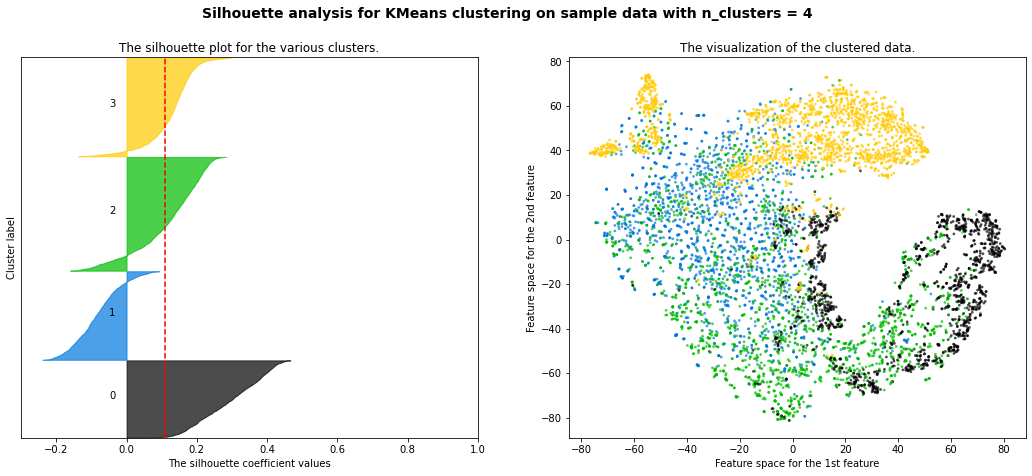

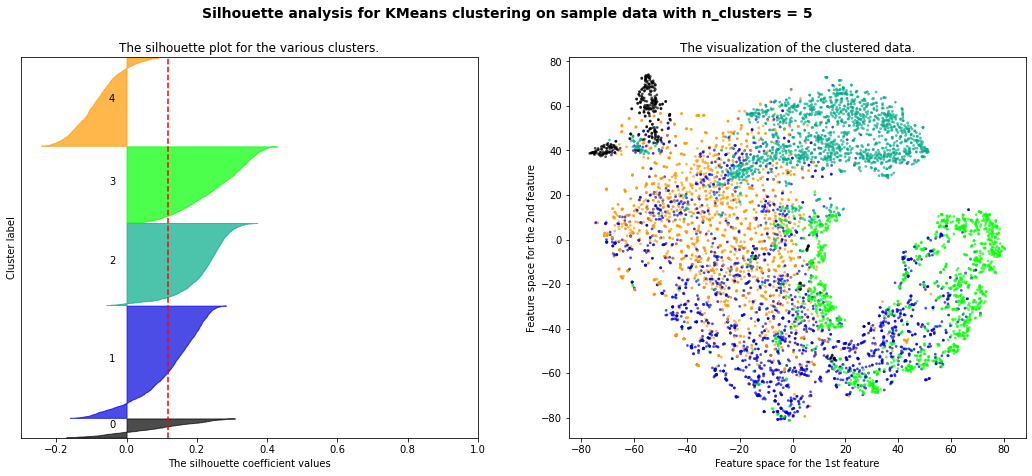

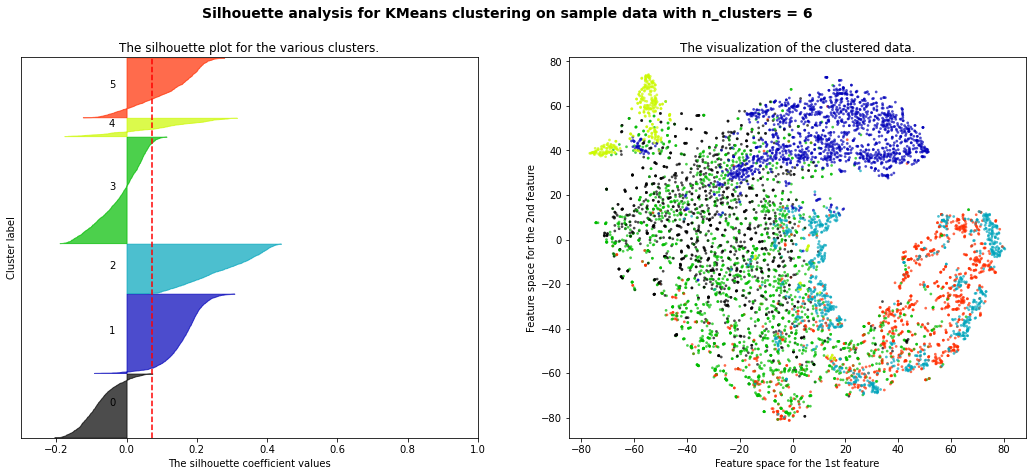

In [30]:
silhouette_scores = []
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.3, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(features) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(features, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(components[:, 0], components[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

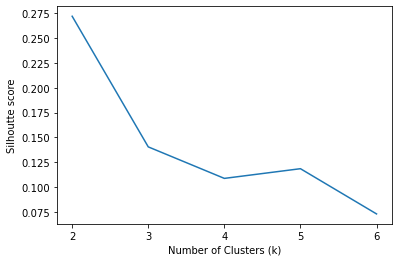

In [31]:
range_n_clusters = [2, 3, 4, 5, 6]

plt.plot(range_n_clusters, silhouette_scores)
ax = plt.gca()
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhoutte score")
ax.set_xticks([2, 3, 4, 5, 6])
plt.show()